In [362]:
### Imports ###

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch.utils.data import DataLoader
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from tqdm.notebook import tqdm

In [363]:
### Define encoder class ###

class VariationalEncoder(nn.Module):
    def __init__(self, input_shape, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_shape, int(input_shape/2))
        self.linear2 = nn.Linear(int(input_shape/2), int(input_shape/3))
        self.linear3 = nn.Linear(int(input_shape/3), int(input_shape/4))
        self.linear4 = nn.Linear(int(input_shape/4), latent_dims) #mu
        self.linear5 = nn.Linear(int(input_shape/4), latent_dims) #logstd
        
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        mu =  self.linear4(x)
        logstd = self.linear5(x)
        z = mu + logstd.exp()*self.N.sample(mu.shape)
        self.kl =  -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))
        return z
    
### Define conditional decoder class ###
class Decoder(nn.Module):
    def __init__(self, input_shape, target_shape, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims+target_shape, int(input_shape/4))
        self.linear2 = nn.Linear(int(input_shape/4)+target_shape, int(input_shape/3))
        self.linear3 = nn.Linear(int(input_shape/3)+target_shape, int(input_shape/2))
        self.linear4 = nn.Linear(int(input_shape/2)+target_shape, input_shape)
        
    def forward(self, z, targets):
        ## targets get concatenated to each layer output in decoder ##
        z = F.relu(self.linear1(torch.cat((z, targets), 1))) 
        z = F.relu(self.linear2(torch.cat((z, targets), 1)))
        z = F.relu(self.linear3(torch.cat((z, targets), 1)))
        z = torch.sigmoid(self.linear4(torch.cat((z, targets), 1)))
        
        return z
    
### CVAE class ###
class CondVariationalAutoencoder(nn.Module):
    def __init__(self, input_shape, target_shape, latent_dims):
        super(CondVariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_shape, latent_dims)
        self.decoder = Decoder(input_shape, target_shape, latent_dims)
    
    def forward(self, x, targets):
        z = self.encoder(x)
        return self.decoder(z, targets)
    
### Function for KL annealing ###
def anneal_schedule(epoch):
    return min(epoch/5,1)

In [364]:
### Load validation data ###

path_input = '/Users/dylansmith/Desktop/CS274E/Project/val_input.npy'
data_target = torch.Tensor(np.load(path_input))

path_target = '/Users/dylansmith/Desktop/CS274E/Project/val_target.npy'
data_input = torch.Tensor(np.load(path_target))

data = torch.cat((data_input, data_target), 1)

train_dataloader = DataLoader(data, batch_size=64, shuffle=True)

In [373]:
### Network parameters ###

latent_dims = 5
input_shape = len(data_input[0])
target_shape = len(data_target[0])
print("Number of data features: ", input_shape)
print("Number of data targets: ", target_shape)
print("Number of validation samples: ", len(data_input))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

cvae = CondVariationalAutoencoder(input_shape, target_shape, latent_dims).to(device) # GPU

Number of data features:  60
Number of data targets:  64
Number of validation samples:  2995200
Device:  cpu


In [366]:
### Load model for evaluation/testing ###

opt = torch.optim.Adam(cvae.parameters())

PATH = "/Users/dylansmith/Desktop/CS274E/Project/cvae_epoch19_5lat.pt"
checkpoint = torch.load(PATH, map_location=device)
cvae.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
mse_loss = checkpoint['recon_loss']
kl_loss = checkpoint['kl_loss']

In [367]:
### View training loss at latest epoch ###

lstkl = [float(i) for i in kl_loss]
lstmse = [float(i) for i in mse_loss]

print("MSE Loss: ", lstmse[-1])
print("KL Divergence: ", lstkl[-1])
print("Total Loss: ", lstkl[-1]+lstmse[-1])

MSE Loss:  0.0022742163855582476
KL Divergence:  1.1920928955078125e-07
Total Loss:  0.0022743355948477983


In [368]:
### Get validation losses ###

data = data.to(device)
opt.zero_grad()
            
inp = data[:,:input_shape]
tar = data[:,-target_shape:]

with torch.no_grad():     
    x_hat = cvae(inp, tar) #Reconstructed samples (with targets)
            
mse = ((inp - x_hat[:,:len(inp[0])])**2).mean() #Reconstruction loss between input and recon data
kl = cvae.encoder.kl
loss = mse + kl

print("Val Reconstruction Loss: ", float(mse))
print("Val KL Divergence: ", float(kl))
print("Validation Loss: ", float(loss))

Val Reconstruction Loss:  0.0020499227102845907
Val KL Divergence:  2.985942515465467e-08
Validation Loss:  0.0020499525126069784


In [369]:
### Get latent vector for validation data ###

with torch.no_grad():
    z = cvae.encoder(inp).detach().numpy()

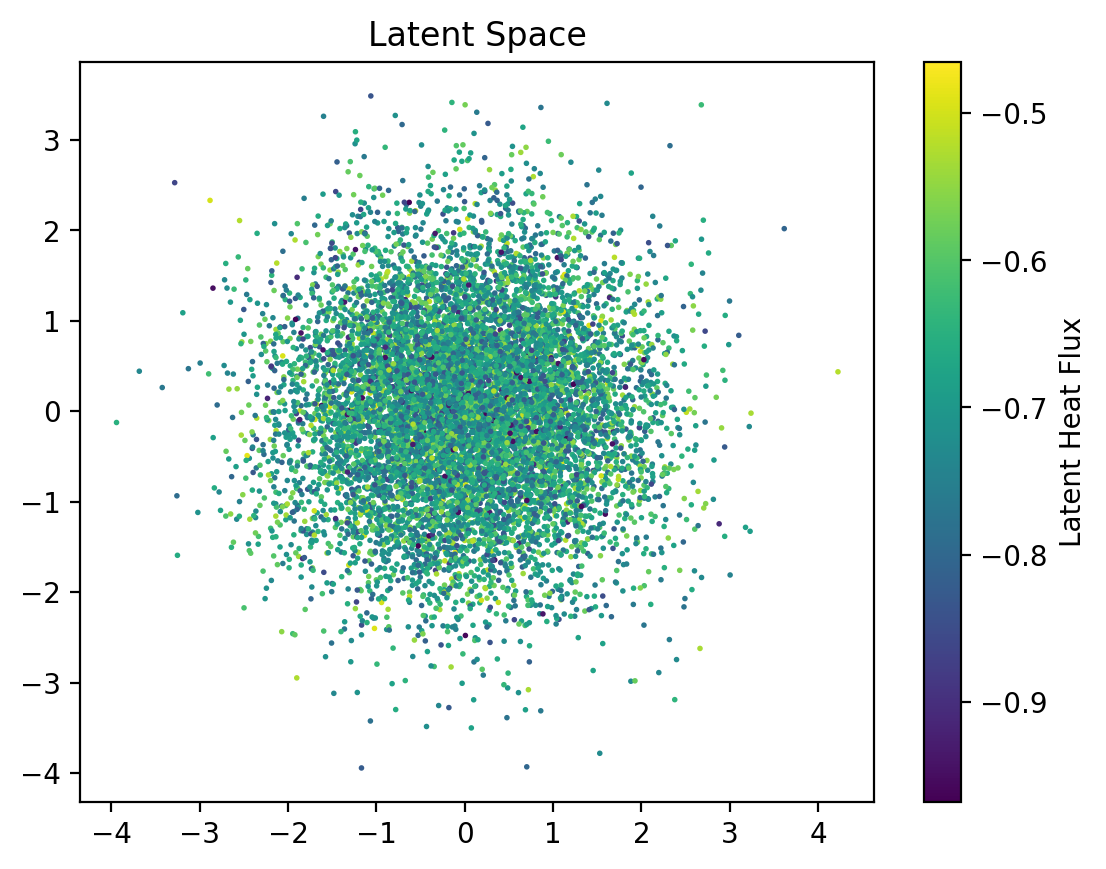

In [370]:
### Plot latent space ###

num_sam = 10000
sc = plt.scatter(z[:num_sam][:, 0], z[:num_sam][:, 1], \
                 c=tar[:num_sam][:,-1].detach().numpy(), \
                 s=1)
plt.colorbar(sc, label="Latent Heat Flux")
plt.title("Latent Space")
plt.show()

In [374]:
### function to get variances for input conditioning vector ###

def var_get(num_samp, tar):
    tarr = tar.tile(num_samp).reshape(num_samp, len(tar))
    rand = torch.rand((num_samp, latent_dims)) #torch.rand(z[:num_samp].shape)
    out = cvae.decoder(rand, tarr)
    
    varys = []
    for i in range(len(out[0])):
        varys.append(float(torch.var(out[:,i])))
    
    return varys

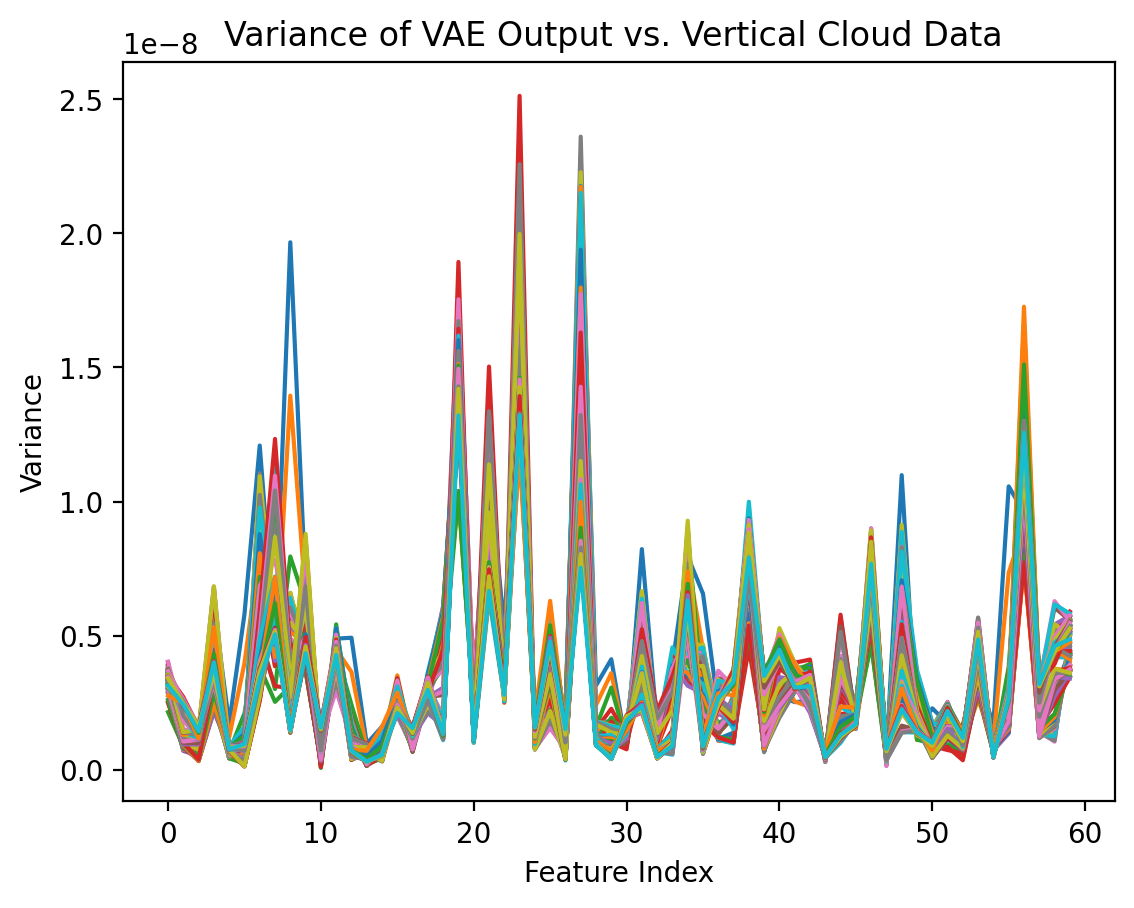

In [377]:
### Plot variances for different conditioning vectors ###

for i in range(100):
    var = var_get(1000, tar[i])
    plt.plot(np.arange(len(var)), var)
plt.title("Variance of VAE Output vs. Vertical Cloud Data ")
plt.ylabel("Variance")
plt.xlabel("Feature Index")
plt.show()